# Data Import and Preprocessing

In [12]:
# All imports, setup logging and get configuration file

from utils import get_configuration_file, setup_logging, impute_null_values
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

setup_logging()
config = get_configuration_file()

In [7]:
# Importing data

holiday_events = pd.read_csv(config["holiday_events_data_location"])
oil = pd.read_csv(config["oil_data_location"])
sample_submission = pd.read_csv(config["sample_submission_data_location"])
stores = pd.read_csv(config["stores_data_location"])
test = pd.read_csv(config["test_data_location"])
train = pd.read_csv(config["train_data_location"])
transactions = pd.read_csv(config["transactions_data_location"])

In [4]:
# Impute null values in oil prices table

oil.rename(columns={"dcoilwtico":"oil_price"},inplace = True)

for index in range(len(oil)):
    if np.isnan(oil.loc[index, "oil_price"]):
        above_oil_price_index = oil["oil_price"][:index].last_valid_index()
        below_oil_price_index = oil["oil_price"][index:].first_valid_index()
        if above_oil_price_index is not None and below_oil_price_index is not None:
            above_oil_price_value = oil.loc[above_oil_price_index, "oil_price"]
            below_oil_price_value = oil.loc[below_oil_price_index, "oil_price"]
            oil.loc[index, "oil_price"] = (above_oil_price_value+below_oil_price_value)/2
        if above_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[above_oil_price_index]
        if below_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[below_oil_price_index]
        
        

In [5]:
# Add holiday column in holiday_events file and rename columns

stores.rename(columns={"type":"store_type"}, inplace = True)
holiday_events.rename(columns={"type":"holiday_type"}, inplace = True)
holiday_events["holiday"] = np.where((holiday_events["holiday_type"].
                                      isin(["Holiday","Transfer","Event",
                                           "Bridge","Additional"]) &
                                     (holiday_events["transferred"]==False)),1,0)
holiday_events_national = holiday_events[holiday_events["locale"]=="National"]

In [6]:
# Merging data

# Merging with Oil data
training_dataset = train.merge(stores, on = "store_nbr", how = "inner")
training_dataset = training_dataset.merge(oil, on = "date", how = "left")

# Merging with holiday events
training_dataset_temp = training_dataset.merge(holiday_events[["date","locale_name",
                                                               "holiday"]], how = "left",
                                                                right_on = 
                                                                ["date","locale_name"], 
                                                                left_on = ["date","city"])
training_dataset_temp.rename(columns={"holiday":"local_holiday"},inplace=True)
training_dataset_temp.drop(columns="locale_name",inplace=True)

training_dataset_temp = training_dataset_temp.merge(holiday_events_national
                                                    [["date","holiday"]],how = "left", 
                                                    left_on = "date", right_on = "date")
training_dataset_temp.rename(columns={"holiday":"national_holiday"},inplace=True)

training_dataset_temp.fillna({"local_holiday":0,"national_holiday":0},inplace = True)

training_dataset = training_dataset_temp

# training_dataset

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,oil_price,local_holiday,national_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,93.14,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,0.0,0.0
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,0.0,0.0
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,0.0,0.0
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,0.0,0.0


In [7]:
# Change data types

training_dataset["date"] = pd.to_datetime(training_dataset["date"])

In [12]:
# Impute Null values

training_dataset = impute_null_values(training_dataset, "oil_price")


In [13]:
# Save the training dataset

# training_dataset.to_csv("training_dataset.csv",index=False)

In [15]:
training_dataset.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
oil_price           0
local_holiday       0
national_holiday    0
dtype: int64

In [99]:
training_dataset.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'local_holiday',
       'national_holiday'],
      dtype='object')

In [97]:
training_dataset.describe()

,id,store_nbr,sales,onpromotion,cluster,dcoilwtico,local_holiday,national_holiday
count,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,3.008280e+06,2.074248e+06,3.008280e+06,3.008280e+06
mean,1.501579e+06,2.750037e+01,3.582643e+02,2.609735e+00,8.481395e+00,6.791413e+01,4.036858e-03,7.996928e-02
std,8.657256e+05,1.558533e+01,1.103486e+03,1.226302e+01,4.649769e+00,2.565828e+01,6.340791e-02,2.712457e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,0.000000e+00,0.000000e+00
25%,7.520698e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.639500e+01,0.000000e+00,0.000000e+00
50%,1.502358e+06,2.800000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.335500e+01,0.000000e+00,0.000000e+00
75%,2.249081e+06,4.100000e+01,1.960000e+02,0.000000e+00,1.300000e+01,9.578500e+01,0.000000e+00,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,1.000000e+00,1.000000e+00


In [136]:
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008280 entries, 0 to 3008279
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       int64         
 6   city              object        
 7   state             object        
 8   store_type        object        
 9   cluster           int64         
 10  oil_price         float64       
 11  local_holiday     float64       
 12  national_holiday  float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(4)
memory usage: 298.4+ MB


# Data Visualization

/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_28908/2909723192.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_28908/2909723192.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_28908/2909723192.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)


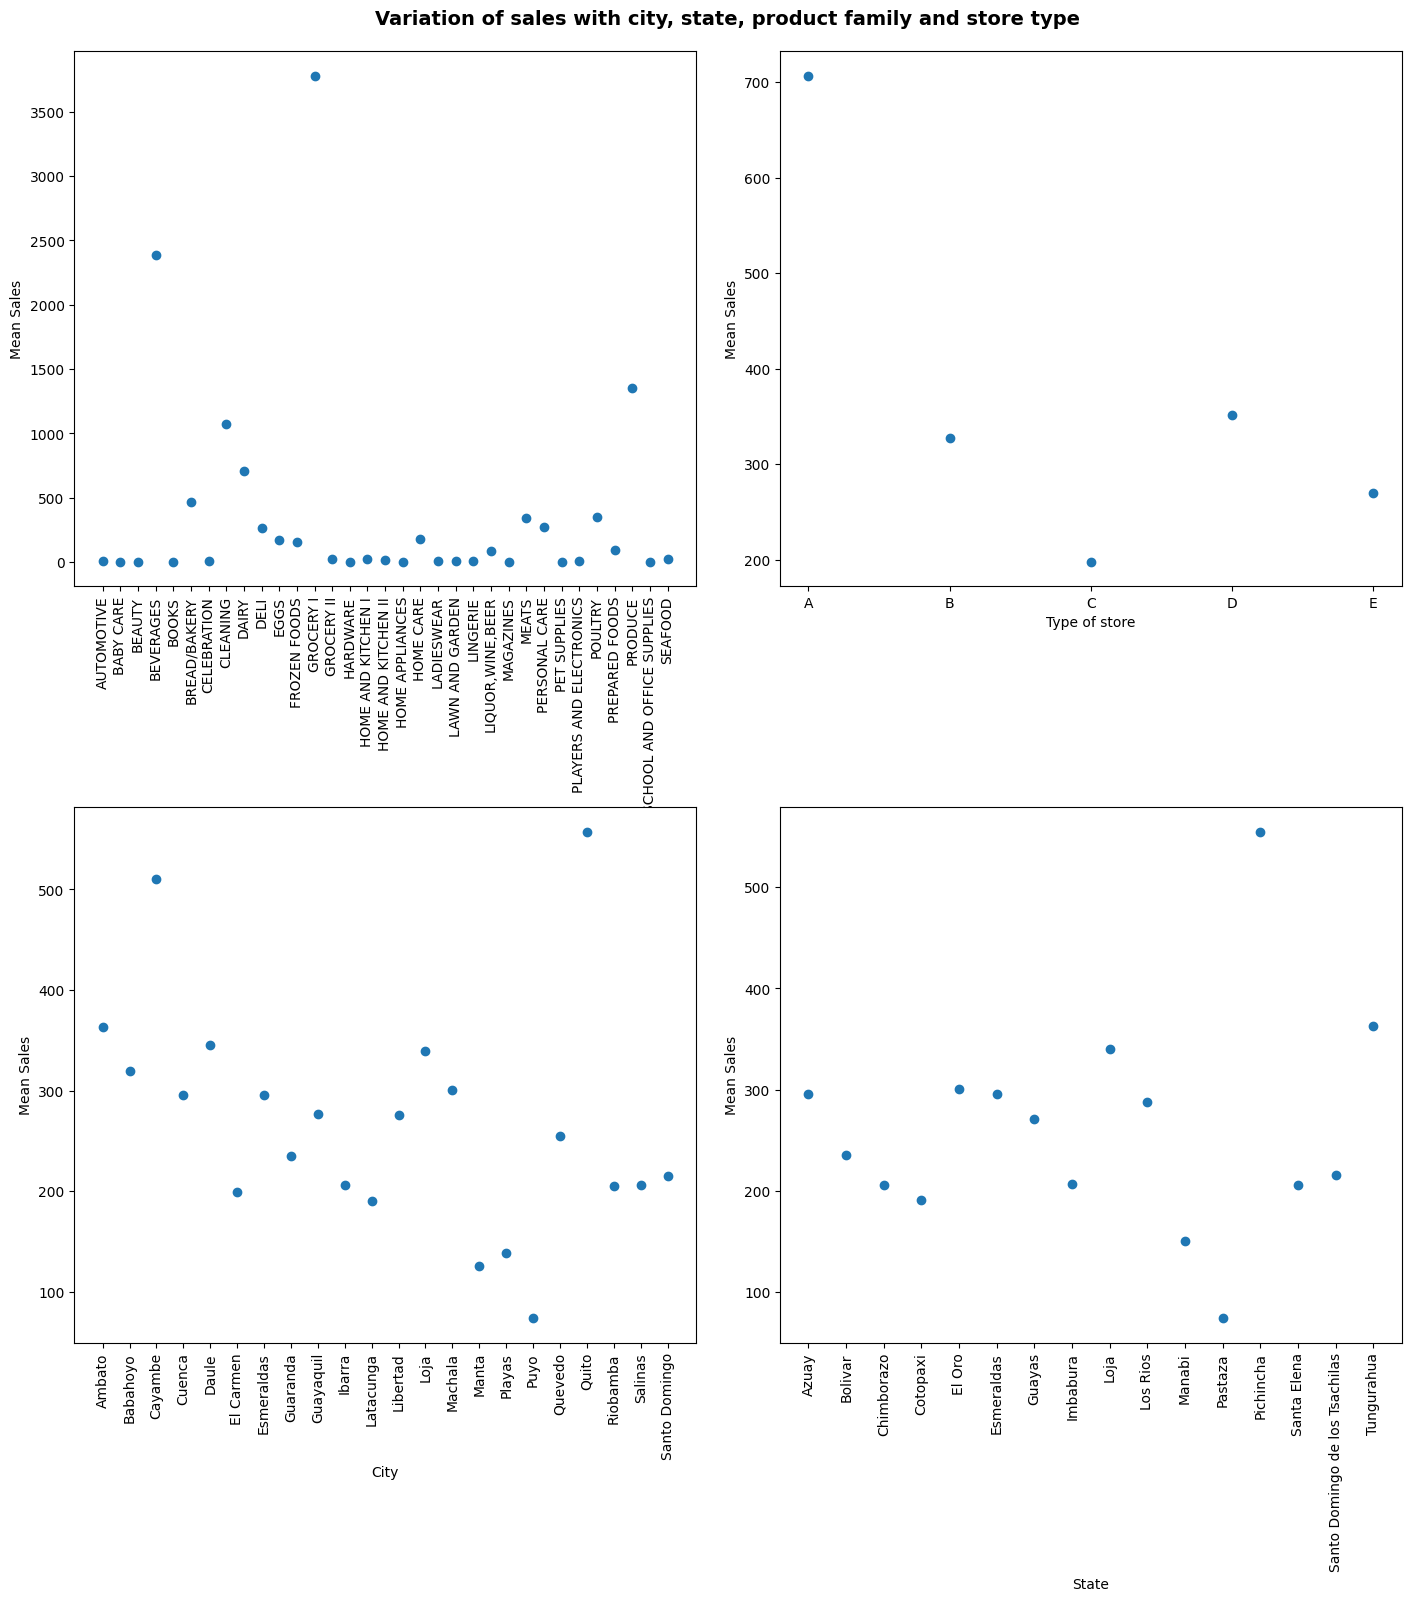

In [75]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
fig.suptitle("Variation of sales with city, state, product family and store type", size = 14, 
             weight = "bold")

fig.tight_layout(h_pad = 14, w_pad = 3)

groupby_column = "family"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
ax[0,0].set_xlabel("Family of products")
ax[0,0].set_ylabel("Mean Sales")

groupby_column = "store_type"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,1].set_xlabel("Type of store")
ax[0,1].set_ylabel("Mean Sales")

groupby_column = "city"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
ax[1,0].set_xlabel("City")
ax[1,0].set_ylabel("Mean Sales")

groupby_column = "state"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)
ax[1,1].set_xlabel("State")
ax[1,1].set_ylabel("Mean Sales")

plt.subplots_adjust(top=0.95)

In [76]:
groupby_column = ["store_nbr","family"]
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
grouped

,store_nbr,family,sales
0,1,AUTOMOTIVE,3.249408
1,1,BABY CARE,0.000000
2,1,BEAUTY,2.408768
3,1,BEVERAGES,1587.809834
4,1,BOOKS,0.125000
...,...,...,...
1777,54,POULTRY,52.835036
1778,54,PREPARED FOODS,61.226303
1779,54,PRODUCE,354.878766
1780,54,SCHOOL AND OFFICE SUPPLIES,0.626185


# Data Preparation for modelling

In [8]:
training_dataset = pd.read_csv("training_dataset.csv")
training_dataset["date"] = pd.to_datetime(training_dataset["date"])
training_dataset = training_dataset.sort_values(by = "date")

In [9]:
X = training_dataset[config["training_columns"]]
y = training_dataset["sales"]

In [10]:
# One hot categorical columns

X = pd.get_dummies(X, columns = config["categorical_columns"], dtype = int)

X.drop(columns = config["encoded_columns_drop"], inplace = True)


# Model training

In [11]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25)

In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
model.score(X_val, y_val)*100

58.2671729204153